In [1]:
import gdown
import zipfile
import os
import faiss
import datasets
import argparse

import typing
import time
from typing import Tuple, Dict
from torch.utils.data import Dataset as TorchDataset
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np
import json
import matplotlib.pyplot as plt


from transformers import AutoTokenizer, RagRetriever, RagSequenceForGeneration, RagConfig, AutoConfig, \
    RagTokenizer, BartForConditionalGeneration, AlbertModel, Trainer, TrainingArguments, BatchEncoding, DataCollatorWithPadding

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.data import DataLoader

from transformers.modeling_outputs import BaseModelOutputWithPooling

from reqs.utils import *

from collections import defaultdict

# remove later
import importlib
import reqs.lightning_base as lightning_base

## Loading the Dataset

In [2]:
url = "https://drive.google.com/uc?id=18xMA2wGPDXArwLyVWN3HXQaF0XnjtugF"
filepath = "data/gold"

# Check if index exists
if os.path.isfile(filepath + "/index.faiss"):
    print("File already exists")
else:

    # Download zip file using gdown
    gdown.download(url, "index.zip", quiet=False)

    # Create directory if it doesn't exist
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Unzip file
    with zipfile.ZipFile("index.zip", 'r') as zip_ref:
        zip_ref.extractall(filepath)

    # Remove zip file
    os.remove("index.zip")

File already exists


In [3]:
# Loading arguments
hparams = parse_sh_args("fine_tune_rag.sh")

## Creating the Model

In [4]:
encoder_model_name = "sentence-transformers/paraphrase-albert-base-v2"
encoder_model_type = "albert"
encoder_config = AutoConfig.from_pretrained(encoder_model_name, output_hidden_states=True)

generator_model_name = "facebook/bart-base"
generator_model_type = "bart"
generator_config = AutoConfig.from_pretrained(generator_model_name)

In [5]:
rag_config = RagConfig(
    question_encoder={
        "model_type": encoder_model_type,
        "config": encoder_config,
    },
    generator = {
        "model_type": generator_model_type,
        "config": generator_config
    },
    index_name="custom",
    passages_path=filepath + "/dataset",
    index_path=filepath + "/index.faiss",
)

extra_model_params = ("encoder_layerdrop", "decoder_layerdrop", "attention_dropout", "dropout")
hparams, rag_config = set_extra_model_params(extra_model_params, hparams, rag_config)


In [6]:
rag_retriever = RagRetriever(
    config=rag_config,
    question_encoder_tokenizer = AutoTokenizer.from_pretrained(encoder_model_name),
    generator_tokenizer = AutoTokenizer.from_pretrained(generator_model_name),
)

In [7]:
class CustomQuestionEncoder(AlbertModel):
    def forward(self, *args, **kwargs):
        # Call the original forward method
        outputs = super().forward(*args, **kwargs)
        attention_mask = kwargs.get('attention_mask', None)

        if attention_mask is None:
            # Assume all 1s if not given, use output to get mask. The final output must be two-dimensional
            attention_mask = torch.ones(outputs[0].shape[:2], device=outputs[0].device)


        token_embeddings = outputs[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        pooler_output = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

        # Return pooler output, hidden states and attentions
        return BaseModelOutputWithPooling(pooler_output=pooler_output, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

# Use the custom question encoder
question_encoder_model = CustomQuestionEncoder.from_pretrained(encoder_model_name)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rag_model = RagSequenceForGeneration(
    config=rag_config,
    retriever=rag_retriever,
    question_encoder=question_encoder_model,
    generator=BartForConditionalGeneration.from_pretrained(generator_model_name),
)

rag_tokenizer = RagTokenizer(
    question_encoder=AutoTokenizer.from_pretrained(encoder_model_name),
    generator=AutoTokenizer.from_pretrained(generator_model_name),
)

## Loading base dataset

In [9]:
questions_dataset = load_dataset("web_questions")

print(questions_dataset)
print(questions_dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['url', 'question', 'answers'],
        num_rows: 3778
    })
    test: Dataset({
        features: ['url', 'question', 'answers'],
        num_rows: 2032
    })
})
{'url': 'http://www.freebase.com/view/en/justin_bieber', 'question': 'what is the name of justin bieber brother?', 'answers': ['Jazmyn Bieber', 'Jaxon Bieber']}


In [10]:
# Create val set using 20% of the training set
train_dataset = questions_dataset["train"]
split_dataset = train_dataset.train_test_split(test_size=0.2, shuffle=False)

# Combine the training and validation and test sets
complete_dataset = DatasetDict({
    "train": split_dataset["train"],
    "val": split_dataset["test"],
    "test": questions_dataset["test"]
})

print(complete_dataset)


DatasetDict({
    train: Dataset({
        features: ['url', 'question', 'answers'],
        num_rows: 3022
    })
    val: Dataset({
        features: ['url', 'question', 'answers'],
        num_rows: 756
    })
    test: Dataset({
        features: ['url', 'question', 'answers'],
        num_rows: 2032
    })
})


In [11]:
# Go over each split, and create the answer column. If multiple answers are present in answers, create a new row for each answer
dataset = complete_dataset["train"]
new_rows = []
for i, row in enumerate(dataset):
    answers = row["answers"]
    for answer in answers:
        new_row = row.copy()
        new_row["answer"] = answer
        new_rows.append(new_row)
complete_dataset["train"] = Dataset.from_pandas(pd.DataFrame(new_rows))

# for val and test add the answer column which is the first answer in the list
for split in ["val", "test"]:
    dataset = complete_dataset[split]
    new_rows = []
    for i, row in enumerate(dataset):
        new_row = row.copy()
        new_row["answer"] = row["answers"][0]
        new_rows.append(new_row)
    complete_dataset[split] = Dataset.from_pandas(pd.DataFrame(new_rows))

print(complete_dataset)

DatasetDict({
    train: Dataset({
        features: ['url', 'question', 'answers', 'answer'],
        num_rows: 7137
    })
    val: Dataset({
        features: ['url', 'question', 'answers', 'answer'],
        num_rows: 756
    })
    test: Dataset({
        features: ['url', 'question', 'answers', 'answer'],
        num_rows: 2032
    })
})


## Initial Testing

In [12]:
rag_model.to(device)

def generate_answer(question, rag_model, rag_tokenizer, rag_retriever, device):
    inputs = rag_tokenizer.question_encoder(question, return_tensors="pt").to(device)

    generated = rag_model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=50, num_beams=1, early_stopping=False)
    generated_string = rag_tokenizer.batch_decode(generated, skip_special_tokens=True)[0]

    # I could not figure out an easier way to get the context
    hidden_states = rag_model.question_encoder(**inputs).pooler_output
    context_input_ids = rag_retriever(
                    inputs["input_ids"],
                    hidden_states.cpu().detach().to(torch.float32).numpy(),
                    prefix=rag_model.generator.config.prefix,
                    n_docs=1,
                    return_tensors="pt",
                )["context_input_ids"]

    context = rag_tokenizer.decode(context_input_ids[0], skip_special_tokens=True)

    return question, context, generated_string

question = complete_dataset["train"][0]["question"]
question, context, generated_string = generate_answer(question, rag_model, rag_tokenizer, rag_retriever, device)

print("Question:", question)
print("Context:", context)
print("Answer:", generated_string)

c:\Users\User\.conda\envs\nlp\Lib\site-packages\transformers\models\bart\modeling_bart.py:590: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Question: what is the name of justin bieber brother?
Context: Justin Bieber / which he talks about God's forgiveness. Bieber was baptized on January 9, 2014, by Pentecostal pastor Carl Lentz of Hillsong Church, New York, after a born again experience. He has described Lentz as a good friend. In 2021, he announced that he had become a member of Churchome, an evangelical church. On July 24, 2021, Bieber led worship with Gospel singers Kari Jobe and Cody Carnes during the "Freedom Experience" at SoFi Stadium. The trio sang "The Blessing".When asked how he wants to raise his children, Bieber replied, "I'm a Jesus follower. When you accept Jesus, you walk with // what is the name of justin bieber brother?
Answer: Justin Bieber / which he talks about God's forgiveness. Bieber was baptized on January 9, 2014, by Pentecostal pastor Carl Lentz of Hillsong Church, New York, after a born again experience. He has described Lentz


In [13]:
# Adapted from https://github.com/huggingface/transformers/blob/main/examples/research_projects/rag/utils_rag.py

class Seq2SeqDataset(TorchDataset):
    def __init__(
        self,
        tokenizer,
        dataset,
        max_source_length,
        max_target_length,
        split="train",
        prefix="",
    ):
        super().__init__()
        self.dataset = dataset[split]
        self.src_lens = [len(x) for x in self.dataset['question']]
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.tokenizer = tokenizer
        self.prefix = prefix

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index) -> Dict[str, torch.Tensor]:
        source_line = self.prefix + self.dataset['question'][index]
        tgt_line = self.dataset['answer'][index]

        # Pad source and target to the right
        source_inputs = encode_line(self.tokenizer.question_encoder, source_line, self.max_source_length, "right")
        target_inputs = encode_line(self.tokenizer.generator, tgt_line, self.max_target_length, "right")

        source_ids = source_inputs["input_ids"].squeeze()
        target_ids = target_inputs["input_ids"].squeeze()
        src_mask = source_inputs["attention_mask"].squeeze()

        return {
            "input_ids": source_ids,
            "attention_mask": src_mask,
            "decoder_input_ids": target_ids,
            "index" : index,
        }


    def collate_fn(self, batch) -> Dict[str, torch.Tensor]:
        input_ids = torch.stack([x["input_ids"] for x in batch])
        masks = torch.stack([x["attention_mask"] for x in batch])
        target_ids = torch.stack([x["decoder_input_ids"] for x in batch])
        index = torch.tensor([x["index"] for x in batch])
        

        y = trim_batch(target_ids, self.tokenizer.generator.pad_token_id)

        source_ids, source_mask = trim_batch(input_ids, self.tokenizer.question_encoder.pad_token_id, attention_mask=masks)
        batch = {
            "input_ids": source_ids,
            "attention_mask": source_mask,
            "decoder_input_ids": y,
            "index": index,
        }
        return batch

## Fine-tuning Code

In [14]:
# Adapted from https://github.com/huggingface/transformers/blob/main/examples/research_projects/rag/finetune_rag.py#L97

class GenerativeQAModule(lightning_base.BaseTransformer):
    mode = "generative_qa"
    loss_names = ["loss"]
    metric_names = ["em"] # exact match
    val_metric = "em"

    def __init__(self, hparams, **kwargs):
        # Global variables used here from simplicity
        self.dataset = complete_dataset
        self.retriever = rag_retriever
        prefix = rag_config.question_encoder.prefix
        super().__init__(hparams, config=rag_config, tokenizer=rag_tokenizer, model=rag_model)
        self.dataset_kwargs = {
            "prefix": prefix,
            "max_source_length": self.hparams.max_source_length,
            "max_target_length": self.hparams.max_target_length,
            "data_dir": self.hparams.data_dir,
        }

        self.training_outputs = []
        self.validation_outputs = []
        self.test_outputs = []

        self.metrics = defaultdict(list)

        self.metrics_save_path = "outputs/metrics.json"

        # Why is this a pickle?
        self.hparams_save_path = "outputs/hparams.pkl"

    def forward(self, input_ids, attention_mask=None, **kwargs):
        return self.model(input_ids, attention_mask=attention_mask, **kwargs)

    def ids_to_clean_text(self, generated_ids):
        preds = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        return lmap(str.strip, preds)

    def _step(self, batch: dict) -> Tuple:
        source_ids, source_mask, target_ids = batch["input_ids"], batch["attention_mask"], batch["decoder_input_ids"]

        rag_kwargs = {}
        decoder_input_ids = target_ids
        lm_labels = decoder_input_ids
        rag_kwargs["reduce_loss"] = True

        assert decoder_input_ids is not None

        outputs = self(
            source_ids,
            attention_mask=source_mask,
            decoder_input_ids=decoder_input_ids,
            use_cache=False,
            labels=lm_labels,
            **rag_kwargs,
        )

        loss = outputs["loss"]
        return (loss,)

    def training_step(self, batch, batch_idx) -> Dict:
        loss_tensors = self._step(batch)

        logs = {name: loss.detach() for name, loss in zip(self.loss_names, loss_tensors)}

        logs["tpb"] = (
            batch["input_ids"].ne(self.tokenizer.question_encoder.pad_token_id).sum() +
            batch["decoder_input_ids"].ne(self.tokenizer.generator.pad_token_id).sum()
        )

        self.training_outputs.append(logs)
        return {"loss": loss_tensors[0], "log": logs}

    def validation_step(self, batch, batch_idx) -> Dict:
        output = self._generative_step(batch)
        self.validation_outputs.append(output)
        return output

    def on_validation_epoch_end(self, prefix="val") -> Dict:
        if prefix == "val":
            outputs = self.validation_outputs
        elif prefix == "test":
            outputs = self.test_outputs

        self.step_count += 1
        losses = {k: torch.stack([x[k] for x in outputs]).mean() for k in self.loss_names}
        loss = losses["loss"]

        gen_metrics = {
            k: np.array([x[k] for x in outputs]).mean() for k in self.metric_names + ["gen_time", "gen_len"]
        }

        metrics_tensor: torch.FloatTensor = torch.tensor(gen_metrics[self.val_metric]).type_as(loss)
        gen_metrics.update({k: v.item() for k, v in losses.items()})

        losses.update(gen_metrics)
        metrics = {f"{prefix}_avg_{k}": x for k, x in losses.items()}
        preds = flatten_list([x["preds"] for x in outputs])

        outputs.clear()
        logs = {"log": metrics, "preds": preds, f"{prefix}_loss": loss, f"{prefix}_{self.val_metric}": metrics_tensor}

        self.save_metrics(metrics, prefix)

        return logs
    
    def save_metrics(self, latest_metrics, type_path) -> None:
        self.metrics[type_path].append(latest_metrics)
        save_json(self.metrics, self.metrics_save_path)

    def calc_generative_metrics(self, preds, target_indices) -> Dict:
        target_indices = target_indices.tolist()
        targets = self.dataset["val"][target_indices]["answers"]
        return calculate_exact_match(preds, targets)

    def _generative_step(self, batch: dict) -> dict:

        start_time = time.time()
        batch = BatchEncoding(batch).to(device=self.model.device)
        generated_ids = self.model.generate(
            batch["input_ids"],
            attention_mask=batch["attention_mask"],
            do_deduplication=False,  # rag specific parameter
            use_cache=True,
            min_length=1,
            max_length=self.hparams.max_target_length,
            num_beams=1,
            early_stopping=False
        )

        gen_time = (time.time() - start_time) / batch["input_ids"].shape[0]
        preds: List[str] = self.ids_to_clean_text(generated_ids)
        target: List[str] = self.ids_to_clean_text(batch["decoder_input_ids"])
        indices = batch["index"]
        loss_tensors = self._step(batch)
        base_metrics = dict(zip(self.loss_names, loss_tensors))
        gen_metrics: Dict = self.calc_generative_metrics(preds, indices)

        summ_len = np.mean(lmap(len, generated_ids))
        base_metrics.update(gen_time=gen_time, gen_len=summ_len, preds=preds, target=target, **gen_metrics)
        return base_metrics

    def test_step(self, batch, batch_idx):
        output = self._generative_step(batch)
        self.test_outputs.append(output)
        return output

    def on_test_epoch_end(self):
        return self.on_validation_epoch_end(prefix="test")
    
    def on_train_epoch_end(self):
        # Just Save loss
        losses = {k: torch.stack([x[k] for x in self.training_outputs]).mean() for k in self.loss_names}
        loss_dict = {f"train_avg_{k}": v.item() for k, v in losses.items()}
        self.save_metrics(loss_dict, "train")
        self.training_outputs.clear()
        return loss_dict


    def get_dataset(self, type_path) -> Seq2SeqDataset:
        dataset = Seq2SeqDataset(
            tokenizer=self.tokenizer,
            dataset=self.dataset,
            split=type_path,
            max_target_length=self.hparams.max_target_length,
            max_source_length=self.hparams.max_source_length,
        )
        return dataset

    def get_dataloader(self, type_path: str, batch_size: int, shuffle: bool = False) -> DataLoader:
        dataset = self.get_dataset(type_path)

        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            collate_fn=dataset.collate_fn,
            shuffle=shuffle,
            num_workers=0, # Prevent notebook hanging
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        dataloader = self.get_dataloader("train", batch_size=self.hparams.train_batch_size, shuffle=True)
        return dataloader

    def val_dataloader(self) -> DataLoader:
        return self.get_dataloader("val", batch_size=self.hparams.eval_batch_size)

    def test_dataloader(self) -> DataLoader:
        return self.get_dataloader("test", batch_size=self.hparams.eval_batch_size)


In [15]:
model = GenerativeQAModule(hparams=hparams)

# Convert hparams
class HParams:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

hparamsObject = HParams(hparams)

In [16]:
# Set precision for matrix multiplication
torch.set_float32_matmul_precision('medium')

early_stop_callback = EarlyStopping(
   monitor='val_avg_em',  # metric to monitor, we use exact match since our loss does not account for multiple correct answers
   min_delta=0.00,  # minimum change in the monitored metric to qualify as improvement
   patience=2,  # number of epochs with no improvement after which training will be stopped
   verbose=True,  # verbosity mode
   mode='max'  # mode: 'min' if we want to minimize the monitored metric, 'max' if we want to maximize it
)

trainer = lightning_base.generic_train(
    model,
    hparamsObject,
    max_epochs=hparamsObject.max_epochs,
    logging_callback=Seq2SeqLoggingCallback(),
    checkpoint_callback=get_checkpoint_callback(model.hparams.output_dir, metric=model.val_metric),
    callbacks=[early_stop_callback],
    accelerator="cuda",
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                     | Params
---------------------------------------------------
0 | model | RagSequenceForGeneration | 151 M 
---------------------------------------------------
151 M     Trainable params
0         Non-trainable params
151 M     Total params
604.416   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\User\.conda\envs\nlp\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
c:\Users\User\.conda\envs\nlp\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Removed shared tensor {'rag.generator.model.encoder.embed_tokens.weight', 'rag.generator.lm_head.weight', 'rag.generator.model.decoder.embed_tokens.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


Validation: |          | 0/? [00:00<?, ?it/s]

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
c:\Users\User\.conda\envs\nlp\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Testing tuned model

In [ ]:
question = "What is the capital of France?"
rag_model.eval()
rag_model.to(device)
question, context, generated_string = generate_answer(question, rag_model, rag_tokenizer, rag_retriever, device)
print("Question:", question)
print("Context:", context)
print("Answer:", generated_string)

Question: What is the capital of France?
Context: French Revolution / and decolonisation.  // what is the capital of france?
Answer: 


In [ ]:
# Use encoder and model.generate to generate answers over the test set

def generate_answer_batch(batch):
    inputs = rag_tokenizer.question_encoder.batch_encode_plus(batch["question"], return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = rag_model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=hparamsObject.max_target_length, num_beams=1, early_stopping=False)
    outputs = [rag_tokenizer.decode(generated, skip_special_tokens=True) for generated in outputs]
    return {"predictions": outputs}

questions_dataset['test'] = questions_dataset['test'].map(generate_answer_batch, batched=True, batch_size=hparamsObject.eval_batch_size)

Map:   0%|          | 0/2032 [00:00<?, ? examples/s]

In [ ]:
# Calculate exact match, cry
exact_match = calculate_exact_match(questions_dataset['test']['predictions'], questions_dataset['test']['answers'], questions_dataset['test']['question'])
print(exact_match)

{'em': 0.002952755905511811}


In [10]:
def plot_losses(train_losses, val_losses):

    # Plot the training and validation losses
    plt.plot(train_losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.legend()

    # Label the axes and title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')

    # Make x axis discrete
    plt.xticks(range(len(train_losses)))
    plt.show()

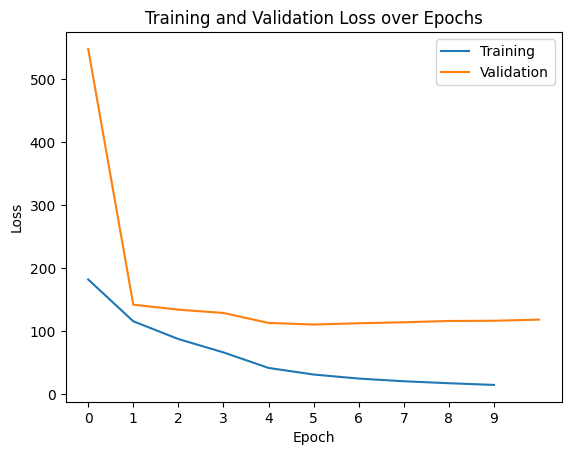

In [11]:
file_path = 'outputs/metrics.json'

with open(file_path, 'r') as file:
    data = json.load(file)

df_val = pd.DataFrame(data['val'])
df_train = pd.DataFrame(data['train'])

plot_losses(df_train['train_avg_loss'], df_val['val_avg_loss'])

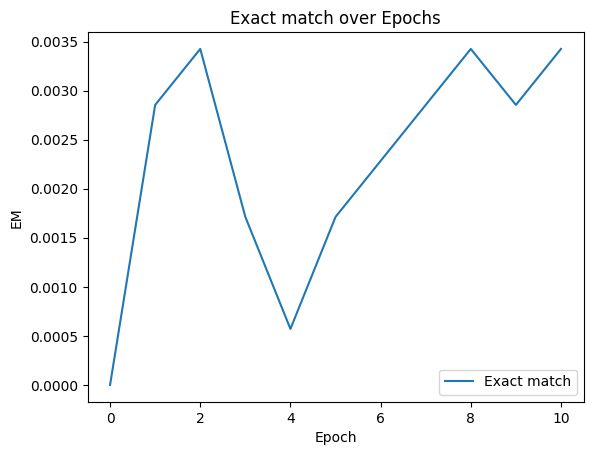

In [12]:
# Plot the training and validation losses
plt.plot(df_val['val_avg_em'], label='Exact match')
plt.legend()

# Label the axes and title
plt.xlabel('Epoch')
plt.ylabel('EM')
plt.title('Exact match over Epochs')

# Make x axis discrete
#plt.xticks(range(len(train_losses)))
plt.show()